In [47]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from functions import display_parallel_coordinates, display_parallel_coordinates_centroids

warnings.filterwarnings("ignore", category=DeprecationWarning) # to avoid deprecation warnings

In [21]:
df = pd.read_csv('uber-raw-data-sep14.csv')

In [22]:
df.head()

,Date/Time,Lat,Lon,Base
0,9/1/2014 0:01:00,40.2201,-74.0021,B02512
1,9/1/2014 0:01:00,40.7500,-74.0027,B02512
2,9/1/2014 0:03:00,40.7559,-73.9864,B02512
3,9/1/2014 0:06:00,40.7450,-73.9889,B02512
4,9/1/2014 0:11:00,40.8145,-73.9444,B02512


In [23]:
df.shape

(1028136, 4)

# Preprocessing

In [24]:
df['Date/Time'] = pd.to_datetime(df['Date/Time'],format='%m/%d/%Y %H:%M:%S')

In [25]:
df['Date/Time'] = pd.to_datetime(df['Date/Time'],format='%m/%d/%Y %H:%M:%S')
df['Day'] = df['Date/Time'].dt.day
df['DayOfWeek'] = df['Date/Time'].dt.dayofweek
df['Month'] = df['Date/Time'].dt.month
df['Year'] = df['Date/Time'].dt.year
df['Hour'] = df['Date/Time'].dt.hour
df['Minute'] = df['Date/Time'].dt.minute

In [26]:
df = df.drop('Date/Time', axis=1)

In [27]:
df.isna().sum()

Lat          0
Lon          0
Base         0
Day          0
DayOfWeek    0
Month        0
Year         0
Hour         0
Minute       0
dtype: int64

In [28]:
df.head()

,Lat,Lon,Base,Day,DayOfWeek,Month,Year,Hour,Minute
0,40.2201,-74.0021,B02512,1,0,9,2014,0,1
1,40.7500,-74.0027,B02512,1,0,9,2014,0,1
2,40.7559,-73.9864,B02512,1,0,9,2014,0,3
3,40.7450,-73.9889,B02512,1,0,9,2014,0,6
4,40.8145,-73.9444,B02512,1,0,9,2014,0,11


In [29]:
numeric_features = ['Lat', 'Lon', 'DayOfWeek', 'Hour']
#categorical_features = ['Base']

In [30]:
# Create pipeline for numeric features
numeric_transformer = Pipeline(steps=[
    #('imputer', SimpleImputer()), 
    ('scaler', StandardScaler())
])

# Create pipeline for categorical features
categorical_transformer = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # missing values will be replaced by most frequent value
    ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ])

# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        #('cat', categorical_transformer, categorical_features)
    ])


In [31]:
X = preprocessor.fit_transform(df)

In [32]:
X

array([[-12.71465439,  -0.51931048,  -1.52451418,  -2.36003662],
       [  0.26399745,  -0.52959958,  -1.52451418,  -2.36003662],
       [  0.40850405,  -0.25007886,  -1.52451418,  -2.36003662],
       ...,
       [  2.75979784,   0.68451499,  -1.00973245,   1.32428931],
       [ -0.76224431,  -0.59647878,  -1.00973245,   1.32428931],
       [ -0.61773772,   0.38098635,  -1.00973245,   1.32428931]])

## EDA

#### Analysis By Weakdays

In [33]:
temp = df['DayOfWeek'].value_counts().reset_index().rename(columns={'index':'day','DayOfWeek':'count'})

<AxesSubplot:title={'center':'Bar Plot for Weekdays trips'}, xlabel='day'>

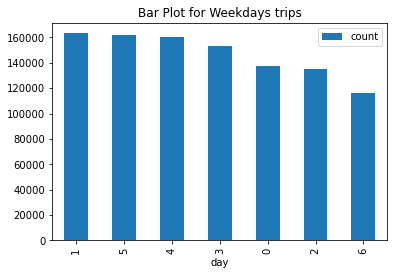

In [34]:
temp.plot(
    kind='bar',
    x='day',
    y='count',
    title='Bar Plot for Weekdays trips'
)

#### Analysis By Hours

## Model

##### Select $K$ optimal clusters

##### Elbow Method

In [60]:
# Let's create a loop that will collect the Within-sum-of-square (wcss) for each value K 
# Let's use .inertia_ parameter to get the within sum of square value for each value K 
wcss =  []
k = []
for i in range (2,11): 
    kmeans = KMeans(n_clusters= i, random_state = 0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
    k.append(i)
    # print("WCSS for K={} --> {}".format(i, wcss[-1]))

print(wcss)

# Create DataFrame
wcss_frame = pd.DataFrame(wcss)
k_frame = pd.Series(k)

# Create figure
fig= px.line(
    wcss_frame,
    x=k_frame,
    y=wcss_frame.iloc[:,-1]
)

# Create title and axis labels
fig.update_layout(
    yaxis_title="Inertia",
    xaxis_title="# Clusters",
    title="Inertia per cluster"
)

# Render
#fig.show(renderer="notebook")
# fig.show(renderer="iframe") # if using workspace
fig.show() # if using workspace

[3336911.057294568, 2802149.139160916, 2312861.0371369445, 2049290.22836247, 1825436.60832266, 1678228.4780911664, 1546721.9583715345, 1497530.541558336, 1388440.9864325929]


## Silhouette 👥

Let's now double check with the Silhouette method. We will use Sklearn again to get <a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html?highlight=silhouette#sklearn.metrics.silhouette_score" target="_blank">silhouette scores.</a>

In [ ]:
# Import silhouette score
from sklearn.metrics import silhouette_score

# Computer mean silhouette score
sil = []
k = []

## Careful, you need to start at i=2 as silhouette score cannot accept less than 2 labels 
for i in range (2,11): 
    kmeans = KMeans(n_clusters= i, random_state = 0)
    kmeans.fit(X)
    sil.append(silhouette_score(X, kmeans.predict(X)))
    k.append(i)
    #print("Silhouette score for K={} is {}".format(i, sil[-1]))

print(sil)

# Create a data frame 
cluster_scores=pd.DataFrame(sil)
k_frame = pd.Series(k)

# Create figure
fig = px.bar(data_frame=cluster_scores,  
             x=k, 
             y=cluster_scores.iloc[:, -1]
            )

# Add title and axis labels
fig.update_layout(
    yaxis_title="Silhouette Score",
    xaxis_title="# Clusters",
    title="Silhouette Score per cluster"
)

# Render
#fig.show(renderer="notebook")
# fig.show(renderer="iframe") # if using workspace
fig.show() # if using workspace

In [83]:
# define the model
model = KMeans(n_clusters=4)

# fit the model
model.fit(X)

# the prediction assign each example (pickup) to his cluster
clusters = model.predict(X)

In [ ]:
fig = px.scatter_mapbox(df,
                        lat='Lat', 
                        lon='Lon',
                        color=clusters,
                        zoom=5,
                        height=800,
                        mapbox_style='carto-positron',
                        title='Best locations'
                        )
fig.show(renderer='vscode')

> #### I have my <font color='green'>4 clusters</font>, Go ahead and Analyze those clusters.

## Analysing the results of K-means Clustering

>  I have 4 variables ('Lat', 'Lon', 'DayOfWeek', 'Hour'), We will use PCA to help us reducing the number of dimensions in a dataset so we can Visualize the results in a 2 dimesnions.

In [ ]:
from sklearn.decomposition import PCA

# Create a PCA model to reduce our data to 2 dimensions for visualisation
pca = PCA (n_components=2)
pca.fit(X)
# new PCA space
X_reduced = pca.transform(X)

# Convert to a data frame
X_reduced_df = pd.DataFrame (X_reduced, columns=['PC1', 'PC2'])
X_reduced_df['cluster'] = clusters

# Plot
fig = px.scatter(X_reduced_df, x='PC1', y='PC2', color='cluster')
fig.show()

> ##### We can see 4 clusters is clearly defined but it didn't tell us much. We want to understand what these clusters actually represent.

### Interpreting the meaning of the Clusters

In [81]:
X_columns = [*numeric_features]

In [ ]:
X_clustered = pd.DataFrame(X, columns=X_columns)
X_clustered["cluster"] = clusters
display_parallel_coordinates(X_clustered, 4)

> #### With so many lines, it's a difficult to pick out the characteristics of the clusters.

> #### But Centroid (a new datapoint representing the center of each cluster) is very usefult to summary of each cluster. 

In [ ]:
centroids = pd.DataFrame(model.cluster_centers_, columns=X_columns)
centroids['cluster'] = centroids.index
display_parallel_coordinates_centroids(centroids, 4)